In [96]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
from datetime import datetime
import tqdm # To get status line when scraping
from scipy.spatial import KDTree
from geopy.distance import geodesic
import re
import time
from selenium.webdriver.support.ui import WebDriverWait
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
import matplotlib.pyplot as plt


service = Service(ChromeDriverManager().install())

Jeg starter med at hente stationer 
fra DSBs hjemmeside

In [19]:
url_station = "https://www.dsb.dk/api/stations/getstationlist"
response_station = requests.get(url_station) # submit query with `get` and save response as object
response_station_json = response_station.json() # convert response to a list of dicts
station_df=pd.DataFrame(response_station_json)


Jeg tilføjer variable i stations_df med koordinater

In [ ]:
station_df['stationLatitude'] = station_df['stationLatitude'].str.replace(',', '.').astype(float)
station_df['stationLongitude'] = station_df['stationLongitude'].str.replace(',', '.').astype(float)

In [24]:
#Opretter selvstændig liste
station_names=station_df['stationName']

Jeg fjerner Station fra alle navne, da man ikke kan søge med det på Banedanmarks hjemmeside

In [20]:
# Function to clean station names
def clean_station_name(name):
    # Remove ' Station' if it exists
    return name.replace(' Station', '')

# Apply the function to the list
cleaned_station_names = [clean_station_name(name) for name in station_names]

# Print the cleaned list
#print(cleaned_station_names)

In [45]:
station_df['stationName'] = [clean_station_name(name) for name in station_df['stationName']]


In [49]:
station_df['stationName'] = [
    'Viby Jylland' if station == 'Viby J' else
    'Nivå' if station == 'Nivå Station' else
    'Højby (Fyn)' if station == 'Højby Fyn station' else
    'CPH Lufthavn ✈︎' if station == 'Københavns Lufthavn (CPH Airport)' else
    'Nykbing F' if station == 'Nykøbing sj' else
    'Viby Sj' if station == 'Viby Sjælland' else
    'Aalborg Lufthavn ✈︎' if station == 'Aalborg Lufthavn' else
    station 
    for station in station_df['stationName']
]


In [50]:
station_df

,stationName,stationUrl,stationLatitude,stationLongitude,tags
0,Albertslund,http://www.dsb.dk/kundeservice/stationer/alber...,55.658108,12.353142,"[DSB 7-Eleven, Aflåst cykelparkering]"
1,Alken,http://www.dsb.dk/kundeservice/stationer/alken/,56.0523918,9.8457079,[]
2,Allerød,http://www.dsb.dk/kundeservice/stationer/allerod/,55.8706131,12.3568097,[Aflåst cykelparkering]
3,Arden,http://www.dsb.dk/kundeservice/stationer/arden/,56.769733,9.859934,[]
4,Asnæs,http://www.dsb.dk/kundeservice/stationer/asnas/,55.8099266,11.5032869,[]
...,...,...,...,...,...
315,Ålholm,http://www.dsb.dk/kundeservice/stationer/alholm/,55.672309,12.493092,[Aflåst cykelparkering]
316,Åmarken,http://www.dsb.dk/kundeservice/stationer/amarken/,55.640121,12.499651,[Aflåst cykelparkering]
317,Aarhus H,http://www.dsb.dk/kundeservice/stationer/aarhu...,56.150272,10.204473,"[DSB Salg & Service, DSB 7-Eleven, Salg af udl..."
318,Årslev,http://www.dsb.dk/kundeservice/stationer/arslev/,55.3025617,10.4643343,[]


Jeg ændre manuelt nogle navne, så hjememsiden er i stand til at finde dem. 

In [21]:
cleaned_station_names = ['Nivå' if station == 'Nivå Station' else 'Viby Jylland'if staion == 'Viby J' else 'Højby (Fyn)' if station == 'Højby Fyn station' else 'CPH Lufthavn ✈︎' if station == 'Københavns Lufthavn (CPH Airport)' else 'Nykbing F' if station == 'Nykøbing sj' else 'Viby Sj' if station == 'Viby Sjælland' else 'Aalborg Lufthavn ✈︎'if station == 'Aalborg Lufthavn' else  station for station in cleaned_station_names ]

cleaned_station_names

['Albertslund',
 'Alken',
 'Allerød',
 'Arden',
 'Asnæs',
 'Aulum',
 'Avedøre',
 'Bagsværd',
 'Ballerup',
 'Bedsted Thy',
 'Bernstorffsvej',
 'Birk Centerpark',
 'Birkerød',
 'Bispebjerg',
 'Bjerringbro',
 'Bording',
 'Borris',
 'Borup',
 'Bramming',
 'Brande',
 'Bred',
 'Bredebro',
 'Brejning',
 'Brøndby Strand',
 'Brøndbyøster',
 'Brønderslev',
 'Brøns',
 'Brørup',
 'Buddinge',
 'Bur',
 'Børkop',
 'Carlsberg',
 'Charlottenlund',
 'Danshøj',
 'Dianalund',
 'Dybbølsbro',
 'Dyssegård',
 'Døstrup Sønderjylland',
 'Egedal',
 'Ejby',
 'Emdrup',
 'Engesvang',
 'Esbjerg',
 'Eskilstrup',
 'Espergærde',
 'Farum',
 'Favrholm',
 'Faxe Ladeplads',
 'Flintholm',
 'Fredensborg',
 'Fredericia',
 'Frederiksberg',
 'Frederikshavn',
 'Frederikssund',
 'Frederiksværk',
 'Friheden',
 'Fruens Bøge',
 'Fuglebakken',
 'Faaborg Rutebilstation',
 'Gadstrup',
 'Gelsted',
 'Gentofte',
 'Gilleleje',
 'Give',
 'Gjesing',
 'Glostrup',
 'Glumsø',
 'Gredstedbro',
 'Greve',
 'Grøndal',
 'Gråsten',
 'Guldager',
 'Gøds

In [84]:
#Åbner webdriver,  husk at vælge søgemaskine

# Initialize the Chrome WebDriver
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# URL to navigate to
url = 'https://mittog.dk/da'
driver.get(url)
wait = WebDriverWait(driver, 1)


In [85]:
#Kørt 12.34
#obs Højby (Fyn)
#KBH lufthavn
# Initialize a dictionary to store DataFrames
station_data_2 = {}

# URL to navigate to
homepage_url = 'https://mittog.dk/da'

# Iterate through the filtered station IDs
for station in cleaned_station_names:
    try:
        # Navigate to the homepage at the start of each iteration
        driver.get(homepage_url)

        # Wait for the search box to be present and clickable, then interact with it
        soge = WebDriverWait(driver, 7).until(
            EC.element_to_be_clickable((By.ID, 'downshift-:r0:-input'))
        )
        soge.click()

        # Clear the input field before entering a new station ID
        soge.clear()

        # Send the station ID to the search box
        soge.send_keys(station)

        # Wait for the relevant button to be clickable, then click it
        button = WebDriverWait(driver, 7).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[role="tab"].css-9tac0x'))
        )
        button.click()

        # Add a sleep time to ensure the page has time to load completely before scraping
        time.sleep(4)  # Adjust the sleep time if necessary

        # Wait for the page to load and parse the page source with BeautifulSoup
        WebDriverWait(driver, 7).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'div[role="row"]'))
        )
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')

        # Extract rows of data
        rows = soup.find_all('div', {'role': 'row'})

        # Extract the data from each row
        data = []
        for row in rows:
            cells = row.find_all('div', {'role': 'gridcell'})
            row_data = [cell.get_text(strip=True) for cell in cells]
            if row_data:  # Only add if row_data is not empty
                data.append(row_data)

        # Check if data was extracted successfully
        if data:
            print(f"Data extracted for station {station}")
        else:
            print(f"No data found for station {station}, continuing...")

        # Create a pandas DataFrame for the station
        df = pd.DataFrame(data, columns=['Train Number', 'Time', 'To', 'Track', 'Details'])

        # Store the DataFrame in the dictionary with the station ID as the key
        station_data_2[station] = df

    except Exception as e:
        print(f"Error processing station {station}: {e}")
        continue

# After processing all station IDs, quit the driver
driver.quit()


# Check results
for station, df in station_data.items():
    print(f"Station: {station}")
    print(df.head())  # Display the first few rows of the DataFrame

Data extracted for station Albertslund
Error processing station Albertslund: 5 columns passed, passed data had 7 columns
Data extracted for station Alken
Error processing station Alken: 5 columns passed, passed data had 7 columns
Data extracted for station Allerød
Error processing station Allerød: 5 columns passed, passed data had 7 columns
Data extracted for station Arden
Error processing station Arden: 5 columns passed, passed data had 7 columns
Error processing station Asnæs: Message: 

Data extracted for station Aulum
Error processing station Aulum: 5 columns passed, passed data had 7 columns
Data extracted for station Avedøre
Error processing station Avedøre: 5 columns passed, passed data had 7 columns
Data extracted for station Bagsværd
Error processing station Bagsværd: 5 columns passed, passed data had 7 columns
Data extracted for station Ballerup
Error processing station Ballerup: 5 columns passed, passed data had 7 columns
Data extracted for station Bedsted Thy
Error processi

KeyboardInterrupt: 

##Datacleaning

Her starter noget seriøs cleaning. Jeg indæstter whitespace for forsinkelser og tager den oprindelige afgang.

In [26]:
# Function to insert a whitespace in the middle of a string if it follows the format like '10.3110.33'
def insert_whitespace(time_str):
    match = re.match(r'^(\d{2}\.\d{2})(\d{2}\.\d{2})$', time_str)
    if match:
        return match.group(1) + ' ' + match.group(2)
    return time_str

# Iterate through each DataFrame in the dictionary
for station, df in station_data.items():
    # Apply the function to the 'Time' column
    df['Time'] = df['Time'].apply(insert_whitespace)

In [27]:
def remove_after_whitespace(time_str):
    return time_str.split(' ')[0]

# Iterate through each DataFrame in the dictionary
for station, df in station_data.items():
    # Apply the function to the 'Time' column
    df['Time'] = df['Time'].apply(remove_after_whitespace)

For regionaltoge omdanner jeg, så jeg i stedet for afgangstidspunk får miuntter til næste afgang. Husk at definere et tidspunkt

In [37]:
# Function to check if the time is in the HH.MM format and calculate minutes from 11:00
def calculate_minutes_from_1245(time_str):
    # Regular expression to check if the format is HH.MM
    if re.match(r'^\d{2}\.\d{2}$', time_str):
        hours, minutes = map(int, time_str.split('.'))
        # Calculate minutes from 12:45
        return (hours - 12) * 60 + (minutes - 34)
    else:
        return time_str  # Return the original string if it doesn't match the HH.MM format

# Function to apply the transformation to each DataFrame in the dictionary
def transform_station_data(station_data):
    for station, df in station_data.items():
        df['Minutes_to_next_train'] = df['Time'].apply(calculate_minutes_from_1245)
    return station_data

# Example usage
# Assuming station_data is your dictionary and each entry is a DataFrame with a 'Time' column
transformed_station_data = transform_station_data(station_data)

In [40]:
#Her fjerner jeg 'min' fra s-tog og omdanner 1/2 til 0,5 

# Function to clean and convert the time variable
def clean_and_convert_minutes(value):
    if isinstance(value, str):
        if 'min' in value:
            value = value.replace('min', '').strip()  # Remove 'min'
        if value == '1/2':
            return 0.5  # Convert '1/2' to 0.5
        try:
            return float(value)  # Convert to float if possible
        except ValueError:
            return None  # Handle unexpected formats gracefully
    return float(value)  # If it's already a number, convert to float

# Apply the function to the 'Minutes_to_next_train' variable
def clean_minutes_variable(station_data):
    for station, df in station_data.items():
        df['Minutes_to_next_train'] = df['Minutes_to_next_train'].apply(clean_and_convert_minutes)
    return station_data

# Example usage
# Assuming station_data is your dictionary and each entry is a DataFrame with a 'Minutes_to_next_train' column
station_data = clean_minutes_variable(station_data)

In [41]:
#Kontrollerer regional station

# Access and print the value associated with the key "Silkeborg"
if "Silkeborg" in station_data:
    print("Value for 'Silkeborg':", station_data["Silkeborg"])
else:
    print("Key 'Silkeborg' not found in the dictionary.")

Value for 'Silkeborg':    Train Number   Time        To Track Details  Minutes_to_next_train
0     Rex  5628  13.12  Aarhus H     2                           38.0
1      RA  5345  13.14    Skjern     1                           40.0
2      RA  5338  13.47  Aarhus H     2                           73.0
3     Rex  5632  14.12  Aarhus H     2                           98.0
4      RA  5351  14.14    Skjern     1                          100.0
5      RA  5344  14.47  Aarhus H     2                          133.0
6     Rex  5635  14.49    Struer     1                          135.0
7     Rex  5636  15.12  Aarhus H     2                          158.0
8      RA  5357  15.14    Skjern     1                          160.0
9      RA  5350  15.47  Aarhus H     2                          193.0
10    Rex  5639  15.49    Struer     1                          195.0
11    Rex  5640  16.12  Aarhus H     2                          218.0
12     RA  5361  16.14    Skjern     1                          220

In [36]:
#Kontrollerer med s-tog

if "Sydhavn" in station_data:
    print("Value for 'Sydhavn':", station_data["Sydhavn"])
else:
    print("Key 'Sydhavn' not found in the dictionary.")

Value for 'Sydhavn':    Train Number    Time        To Track Details  Minutes_to_next_train
0             A  1/2min  Hillerød     1                            0.5
1             E    2min      Køge     2                            2.0
2             A    3min   Hundige     2                            3.0
3             E    4min     Holte     1                            4.0
4             A   10min  Hillerød     1                           10.0
5             E   11min      Køge     2                           11.0
6             A   12min   Hundige     2                           12.0
7             E   12min     Holte     1                           12.0
8             A   20min  Hillerød     1                           20.0
9             E   21min      Køge     2                           21.0
10            A   23min   Hundige     2                           23.0
11            E   23min     Holte     1                           23.0
12            A   31min  Hillerød     1                 

Nu beregner jeg, hvor mange afgange der er indenfor 45 minutter. Altså hvor mange afgange der er fra 08.15 til 09.00 tirsdag morgen i august. Jeg gemmer resultatet i en liste. 

In [42]:
# Function to count rows that meet the condition in each DataFrame
def count_valid_departures(station_data):
    station_counts = []

    for station, df in station_data.items():
        # Filter rows with values between 0 and 45 inclusive
        count = df[(df['Minutes_to_next_train'] >= 0) & (df['Minutes_to_next_train'] <= 45)].shape[0]
        station_counts.append({'Station': station, 'Afgange': count})

    # Create a new DataFrame with the results
    result_df = pd.DataFrame(station_counts)

    # Add the additional observations
    additional_stations = [
        {'Station': 'Asnæs', 'Afgange': 2},
        {'Station': 'Dianalund', 'Afgange': 2},
        {'Station': 'Faxe Ladeplads', 'Afgange': 2},
        {'Station': 'Fredensborg', 'Afgange': 2},
        {'Station': 'Frederiksværk', 'Afgange': 5},
        {'Station': 'Gilleleje', 'Afgange': 2},
        {'Station': 'Havdrup', 'Afgange': 2},
        {'Station': 'Helsinge', 'Afgange': 2},
        {'Station': 'Højby (Sjælland)', 'Afgange': 2},
        {'Station': 'Høng', 'Afgange': 2},
        {'Station': 'Hårlev', 'Afgange': 3},
        {'Station': 'Lemvig', 'Afgange': 1},
        {'Station': 'Maribo', 'Afgange': 2},
        {'Station': 'Nakskov', 'Afgange': 1},
        {'Station': 'Nærum', 'Afgange': 1},
        {'Station': 'Rødvig', 'Afgange': 1},
        {'Station': 'Sakskøbing', 'Afgange': 2},
        {'Station': 'Store Heddinge', 'Afgange': 2},
        {'Station': 'Svenstrup', 'Afgange': 2},
        {'Station': 'Søllested', 'Afgange': 2},
    ]

    # Convert the list of dictionaries to a DataFrame and concatenate it with the result_df
    additional_df = pd.DataFrame(additional_stations)
    result_df = pd.concat([result_df, additional_df], ignore_index=True)

    return result_df

# Example usage
# Assuming station_data is your dictionary where each key is a station name and each value is a DataFrame
result_df = count_valid_departures(station_data)

# Show the result

In [56]:
# Perform the left join
station_df = station_df.merge(result_df, how='left', left_on='stationName', right_on='Station')



In [68]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(station_df)

,stationName,stationUrl,stationLatitude,stationLongitude,tags,Station_x,Afgange_x,Station_y,Afgange_y
0,Albertslund,http://www.dsb.dk/kundeservice/stationer/alber...,55.658108,12.353142,"[DSB 7-Eleven, Aflåst cykelparkering]",Albertslund,9.0,Albertslund,9.0
1,Alken,http://www.dsb.dk/kundeservice/stationer/alken/,56.0523918,9.8457079,[],Alken,2.0,Alken,2.0
2,Allerød,http://www.dsb.dk/kundeservice/stationer/allerod/,55.8706131,12.3568097,[Aflåst cykelparkering],Allerød,9.0,Allerød,9.0
3,Arden,http://www.dsb.dk/kundeservice/stationer/arden/,56.769733,9.859934,[],Arden,2.0,Arden,2.0
4,Asnæs,http://www.dsb.dk/kundeservice/stationer/asnas/,55.8099266,11.5032869,[],Asnæs,2.0,Asnæs,2.0
5,Aulum,http://www.dsb.dk/kundeservice/stationer/aulum/,56.265253,8.788423,[],Aulum,3.0,Aulum,3.0
6,Avedøre,http://www.dsb.dk/kundeservice/stationer/avedore/,55.625400,12.454097,[],Avedøre,10.0,Avedøre,10.0
7,Bagsværd,http://www.dsb.dk/kundeservice/stationer/bagsv...,55.7612225,12.4541519,[],Bagsværd,9.0,Bagsværd,9.0
8,Ballerup,http://www.dsb.dk/kundeservice/stationer/balle...,55.7296350,12.3589260,"[DSB 7-Eleven, Aflåst cykelparkering]",Ballerup,12.0,Ballerup,12.0
9,Bedsted Thy,http://www.dsb.dk/kundeservice/stationer/bedst...,56.806831,8.405832,[],Bedsted Thy,2.0,Bedsted Thy,2.0


In [82]:
 station_df.to_csv('station_data.csv', index=False)

In [83]:
#Tjek dette gennem inden færdiggørelse

#station_df[station_df['Afgange_x'] == 0]
station_df[station_df.isnull().any(axis=1)]

,stationName,stationUrl,stationLatitude,stationLongitude,tags,Station_x,Afgange_x,Station_y,Afgange_y
51,Frederiksberg,http://www.dsb.dk/kundeservice/stationer/frede...,55.681314,12.534194,[],NaN,NaN,NaN,NaN
58,Faaborg Rutebilstation,http://www.dsb.dk/kundeservice/stationer/faaborg/,55.093777,10.245588,[],NaN,NaN,NaN,NaN
79,Havdrup,http://www.dsb.dk/kundeservice/stationer/havdrup/,55.543455,12.116982,[],NaN,NaN,NaN,NaN
114,Højby Sjælland,http://www.dsb.dk/kundeservice/stationer/hojby...,55.9109599,11.6039889,[],NaN,NaN,NaN,NaN
135,Kerteminde,http://www.dsb.dk/kundeservice/stationer/kerte...,55.4507277,10.6591745,[],NaN,NaN,NaN,NaN
171,Nivå station,http://www.dsb.dk/kundeservice/stationer/niva/,55.933331,12.506574,[],NaN,NaN,NaN,NaN
175,Nykøbing Mors,http://www.dsb.dk/kundeservice/stationer/nykob...,56.7946266,8.8633832,[],NaN,NaN,NaN,NaN
176,Nykøbing Sj,http://www.dsb.dk/kundeservice/stationer/nykob...,55.921588,11.672552,[],NaN,NaN,NaN,NaN
201,Rudkøbing,http://www.dsb.dk/kundeservice/stationer/rudko...,54.9386142,10.7224375,[],NaN,NaN,NaN,NaN
291,Viby Jylland,http://www.dsb.dk/kundeservice/stationer/viby-j/,56.1214599,10.1598898,[],NaN,NaN,NaN,NaN


Nu har vi et df med alle staioner og deres afgange på 45 minutter efter man har kørt koden, samt kordinater for staionerne. 

Nu henter jeg så data om boliger ned 

List of links
Create a list of links by looping through the pages

In [71]:
# Make empty list
links = []

# Loop through pages
for page in range(1,1120,1):
    url = f"https://api.boliga.dk/api/v2/search/results?sort=views-d&page={page}" #Create URL
    links.append(url) # append url to links
    
links

['https://api.boliga.dk/api/v2/search/results?sort=views-d&page=1',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=2',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=3',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=4',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=5',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=6',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=7',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=8',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=9',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=10',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=11',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=12',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=13',
 'https://api.boliga.dk/api/v2/search/results?sort=views-d&page=14',
 'https://api.boliga.dk/api/v2/search/resul

In [77]:
# Creates empty list of jsonfiles
json_list = []

# Loop through links
for url in tqdm.tqdm(links):
    response = requests.get(url,headers = {'name': 'Tobias Thiim Mølgaard', 'email': 'bmw657@alumni.ku.dk'},
                       verify = False)
    json=response.json() # Turn into json
    json_list.append(json)
    time.sleep(2)

  0%|                                                                                         | 0/1119 [00:00<?, ?it/s]C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|                                                                                 | 1/1119 [00:03<58:06,  3.12s/it]C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|▏                                                                                | 2/1119 [00:06<57:45,  3.10s/it]C:\Us

In [86]:
# Loop through links
response = requests.get(links[-1],headers = {'name': 'Tobias Thiim Mølgaard', 'email': 'bmw657@alumni.ku.dk'},
                       verify = False)
json=response.json() # Turn into json
json_list.append(json)


C:\Users\Tobias Thiim\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.boliga.dk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [87]:
# Create empty DataFrame to append all DataFrames to 
bolig_df = pd.DataFrame()

# Loop through all json-files
for i in range(len(json_list)):
    df = pd.DataFrame(json_list[i]['results'])
    # Append df to bolig_df
    bolig_df = pd.concat([bolig_df, df])

pd.set_option('display.max_columns', None)
bolig_df  

C:\Users\Tobias Thiim\AppData\Local\Temp\ipykernel_12900\327948430.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bolig_df = pd.concat([bolig_df, df])


,id,latitude,longitude,propertyType,priceChangePercentTotal,energyClass,openHouse,price,selfsale,rooms,size,lotSize,floor,buildYear,city,isForeclosure,isActive,municipality,zipCode,street,squaremeterPrice,area,daysForSale,createdDate,isPremiumAgent,images,net,exp,basementSize,inWatchlist,views,agentRegId,domainId,guid,agentDisplayName,groupKey,downPayment,itemType,dawaId,projectSaleUrl,additionalBuildings,lastSeen,businessArea,nonPremiumDiscrete,bfeNr,ouId,ouAddress,onTheWay,cleanStreet,otwAddress,dsAddress,boligaPlus,showLogo,randomTypeHuse
0,1844515,55.67386,12.57692,1,0,d,,100000000,False,12.0,383,213,NaN,1757,København K,False,True,101,1472,Ny Kongensgade 3,261096.0,1,1011,2021-11-11T23:02:32.000Z,False,"[{'id': 1844515, 'date': '2024-08-19T11:37:14....",0,13972,105,False,94443,26472,171,628079F8-F05F-4D4D-A5B4-1AF913E20B7C,,None,5000000,0,None,None,None,2024-08-18T22:39:06.513Z,80.0,False,6027332.0,0,ny-kongensgade-3-1472-koebenhavn-k,False,Ny Kongensgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
1,2124268,55.86242,12.48589,1,0,D,,33000000,False,9.0,274,22071,NaN,1934,Hørsholm,False,True,230,2970,Kirsebærvej 8,120437.0,3,41,2024-07-09T00:07:55.980Z,False,"[{'id': 2124268, 'date': '2024-08-19T11:37:14....",152039,12294,52,False,27678,17998,609,F1B6C7CC-AA4F-43AD-B744-BCEA80F993E4,,None,1650000,0,None,None,None,2024-08-18T23:35:20.493Z,153.0,False,2361211.0,1399883946,kirsebaervej-8-2970-hoersholm,False,Kirsebærvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
2,2082241,55.76980,12.57548,1,0,C,,78000000,False,12.0,456,5252,NaN,1926,Klampenborg,False,True,157,2930,Klampenborgvej 35C,171052.0,2,157,2024-03-14T23:03:35.433Z,False,"[{'id': 2082241, 'date': '2024-08-19T11:37:14....",0,37909,195,False,25958,25254,419,7A2467F3-FCA9-4D3E-98FF-2AAC6AB0D587,,None,3900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,2038042.0,588843670,klampenborgvej-35c-2930-klampenborg,False,Klampenborgvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
3,2088714,55.92461,12.44494,6,-13,J,,42000000,False,9.0,375,40946,NaN,2019,Kokkedal,False,True,210,2980,Fredensborg Kongevej 42,112000.0,3,143,2024-03-28T23:02:51.050Z,False,"[{'id': 2088714, 'date': '2024-08-19T11:37:14....",0,11780,241,False,24429,26800,419,54DCADE6-8FA5-4652-B64F-65A182758CDD,,None,2100000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,7662613.0,0,fredensborg-kongevej-42-2980-kokkedal,False,Fredensborg Kongevej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
4,1990622,55.77462,12.46564,1,-19,E,,58000000,False,14.0,704,3423,NaN,1882,Kongens Lyngby,False,True,173,2800,"Nybrovej 375, Tusculum",82386.0,2,474,2023-05-02T22:05:41.047Z,False,"[{'id': 1990622, 'date': '2024-08-19T11:37:14....",262452,54937,196,False,23382,26763,419,E3313E6F-F2AD-4C6C-834E-94BABF4ACF65,,None,2900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,8864741.0,2120502893,nybrovej-375-2800-kongens-lyngby,False,Nybrovej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2135499,55.66656,12.59319,3,0,I,2024-08-25T11:00:00.000Z,5495000,False,3.0,96,0,2.0,2018,København S,False,True,101,2300,"Bardenflethsgade 1, 2. th.",57239.0,1,0,2024-08-18T23:30:02.253Z,False,"[{'id': 2135499, 'date': '2024-08-19T12:34:53....",25147,4714,0,False,0,17454,11,0E19F64E-6D4D-461B-B9FC-DAC56134F79B,,None,275000,0,None,None,None,2024-08-18T23:30:02.253Z,NaN,False,6004700.0,0,bardenflethsgade-1-2-th-2300-koebenhavn-s,False,Bardenflethsgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
23,2135496,55.45175,12.19246,3,0,J,,6495000,False,4.0,141,0,1.0,2018,Køge,False,True,259,4600,"Søndre Badevej 6C, 1. 3.",46063.0,5,0,2024-08-18T23:30:01.907Z,False,"[{'id': 2135496, 'date'

In [80]:
bolig_df.to_csv('boliger_salg.csv', sep=';', index=False, encoding='utf-8')

In [81]:
bolig_df

,id,latitude,longitude,propertyType,priceChangePercentTotal,energyClass,openHouse,price,selfsale,rooms,size,lotSize,floor,buildYear,city,isForeclosure,isActive,municipality,zipCode,street,squaremeterPrice,area,daysForSale,createdDate,isPremiumAgent,images,net,exp,basementSize,inWatchlist,views,agentRegId,domainId,guid,agentDisplayName,groupKey,downPayment,itemType,dawaId,projectSaleUrl,additionalBuildings,lastSeen,businessArea,nonPremiumDiscrete,bfeNr,ouId,ouAddress,onTheWay,cleanStreet,otwAddress,dsAddress,boligaPlus,showLogo,randomTypeHuse
0,1844515,55.67386,12.57692,1,0,d,,100000000,False,12.0,383,213,NaN,1757,København K,False,True,101,1472,Ny Kongensgade 3,261096.0,1,1011,2021-11-11T23:02:32.000Z,False,"[{'id': 1844515, 'date': '2024-08-19T11:37:14....",0,13972,105,False,94443,26472,171,628079F8-F05F-4D4D-A5B4-1AF913E20B7C,,None,5000000,0,None,None,None,2024-08-18T22:39:06.513Z,80.0,False,6027332.0,0,ny-kongensgade-3-1472-koebenhavn-k,False,Ny Kongensgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
1,2124268,55.86242,12.48589,1,0,D,,33000000,False,9.0,274,22071,NaN,1934,Hørsholm,False,True,230,2970,Kirsebærvej 8,120437.0,3,41,2024-07-09T00:07:55.980Z,False,"[{'id': 2124268, 'date': '2024-08-19T11:37:14....",152039,12294,52,False,27678,17998,609,F1B6C7CC-AA4F-43AD-B744-BCEA80F993E4,,None,1650000,0,None,None,None,2024-08-18T23:35:20.493Z,153.0,False,2361211.0,1399883946,kirsebaervej-8-2970-hoersholm,False,Kirsebærvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
2,2082241,55.76980,12.57548,1,0,C,,78000000,False,12.0,456,5252,NaN,1926,Klampenborg,False,True,157,2930,Klampenborgvej 35C,171052.0,2,157,2024-03-14T23:03:35.433Z,False,"[{'id': 2082241, 'date': '2024-08-19T11:37:14....",0,37909,195,False,25958,25254,419,7A2467F3-FCA9-4D3E-98FF-2AAC6AB0D587,,None,3900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,2038042.0,588843670,klampenborgvej-35c-2930-klampenborg,False,Klampenborgvej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
3,2088714,55.92461,12.44494,6,-13,J,,42000000,False,9.0,375,40946,NaN,2019,Kokkedal,False,True,210,2980,Fredensborg Kongevej 42,112000.0,3,143,2024-03-28T23:02:51.050Z,False,"[{'id': 2088714, 'date': '2024-08-19T11:37:14....",0,11780,241,False,24429,26800,419,54DCADE6-8FA5-4652-B64F-65A182758CDD,,None,2100000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,7662613.0,0,fredensborg-kongevej-42-2980-kokkedal,False,Fredensborg Kongevej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
4,1990622,55.77462,12.46564,1,-19,E,,58000000,False,14.0,704,3423,NaN,1882,Kongens Lyngby,False,True,173,2800,"Nybrovej 375, Tusculum",82386.0,2,474,2023-05-02T22:05:41.047Z,False,"[{'id': 1990622, 'date': '2024-08-19T11:37:14....",262452,54937,196,False,23382,26763,419,E3313E6F-F2AD-4C6C-834E-94BABF4ACF65,,None,2900000,0,None,None,None,2024-08-18T22:31:01.587Z,0.0,False,8864741.0,2120502893,nybrovej-375-2800-kongens-lyngby,False,Nybrovej,None,None,False,False,"{'leisureHouses': [], 'houses': [[{'estateUrl'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,2135499,55.66656,12.59319,3,0,I,2024-08-25T11:00:00.000Z,5495000,False,3.0,96,0,2.0,2018,København S,False,True,101,2300,"Bardenflethsgade 1, 2. th.",57239.0,1,0,2024-08-18T23:30:02.253Z,False,"[{'id': 2135499, 'date': '2024-08-19T12:34:53....",25147,4714,0,False,0,17454,11,0E19F64E-6D4D-461B-B9FC-DAC56134F79B,,None,275000,0,None,None,None,2024-08-18T23:30:02.253Z,NaN,False,6004700.0,0,bardenflethsgade-1-2-th-2300-koebenhavn-s,False,Bardenflethsgade,None,None,False,False,"{'leisureHouses': [], 'houses': []}"
23,2135496,55.45175,12.19246,3,0,J,,6495000,False,4.0,141,0,1.0,2018,Køge,False,True,259,4600,"Søndre Badevej 6C, 1. 3.",46063.0,5,0,2024-08-18T23:30:01.907Z,False,"[{'id': 2135496, 'date'

## Udvælger observationer
1. Fjerner andelsboliger, fritidsboliger og fritidsgrunde
2. Vi har identificeret nogle observationer med meget lav pris, som viser sig at være timeshare, grunde i offentligt udbud mm. Vi fjerner derfor alle observationer med en pris på under 29.500
3. Fjerner dubletter

In [101]:
bolig_df.columns
bolig_df_selected = bolig_df[['id', 'latitude', 'longitude', 'propertyType', 'energyClass', 'price',
                             'rooms', 'size', 'lotSize', 'floor', 'buildYear', 'city', 'isForeclosure',
                             'municipality', 'zipCode', 'street', 'squaremeterPrice', 'area', 
                             'exp', 'basementSize', 'businessArea', 'cleanStreet', 'createdDate']]
print(len(bolig_df))

54927


In [102]:
# 1. Fjerner andelsboliger, fritidshuse og fritidsgrunde
bolig_df_selected = bolig_df_selected[~bolig_df_selected['propertyType'].isin([4,5,8])].reset_index(drop = True)
bolig_df_selected
print(len(bolig_df[bolig_df['propertyType']==5]))
print(len(bolig_df[bolig_df['propertyType']==4]))
print(len(bolig_df[bolig_df['propertyType']==8]))
print(len(bolig_df_selected))
bolig_df_selected[bolig_df_selected['price']==10000]

715
6465
732
47015


,id,latitude,longitude,propertyType,energyClass,price,rooms,size,lotSize,floor,buildYear,city,isForeclosure,municipality,zipCode,street,squaremeterPrice,area,exp,basementSize,businessArea,cleanStreet,createdDate
12984,2065524,56.89526,9.22525,7,-,10000,0.0,0,703,NaN,0,Ranum,False,820,9681,Nygade 10,0.0,11,0,0,NaN,Nygade,2024-01-13T00:57:22.817Z
19021,2070806,56.85630,9.26590,7,-,10000,0.0,0,2667,NaN,0,Løgstør,False,820,9670,"Bjørnsholmvej 177, Overlade",0.0,11,0,0,NaN,Bjørnsholmvej,2024-02-06T00:57:01.653Z
20294,2065559,56.87703,9.28359,7,-,10000,0.0,0,756,NaN,0,Løgstør,False,820,9670,"Munksjørupvej 64, Overlade",0.0,11,0,0,NaN,Munksjørupvej,2024-01-13T00:57:27.373Z
22148,2065570,56.69040,9.33111,7,-,10000,0.0,0,398,NaN,0,Gedsted,False,820,9631,Vesterbro 9,0.0,11,0,0,NaN,Vesterbro,2024-01-13T00:57:28.497Z
23496,2065563,56.85478,9.26264,7,-,10000,0.0,0,1961,NaN,0,Løgstør,False,820,9670,"Mosevej 30, Overlade",0.0,11,0,0,NaN,Mosevej,2024-01-13T00:57:27.853Z
25777,2065561,56.89874,9.21992,7,-,10000,0.0,0,2106,NaN,0,Ranum,False,820,9681,Stadionvej 4,0.0,11,0,0,NaN,Stadionvej,2024-01-13T00:57:27.793Z
25778,2065571,56.67375,9.39907,7,-,10000,0.0,0,1266,NaN,0,Aalestrup,False,820,9620,"Korsvejen 77, Fjelsø",0.0,11,0,0,NaN,Korsvejen,2024-01-13T00:57:29.343Z
26690,2065569,56.71373,9.35613,7,-,10000,0.0,0,1143,NaN,0,Gedsted,False,820,9631,"Tolshøj 20, Vesterbølle",0.0,11,0,0,NaN,Tolshøj,2024-01-13T00:57:28.437Z
26841,2065560,56.90383,9.28472,7,-,10000,0.0,0,425,NaN,0,Løgstør,False,820,9670,"Kirkebakken 7, Vilsted",0.0,11,0,0,NaN,Kirkebakken,2024-01-13T00:57:27.753Z
30826,2065562,56.89670,9.22516,7,-,10000,0.0,0,614,NaN,0,Ranum,False,820,9681,Vestergade 48,0.0,11,0,0,NaN,Vestergade,2024-01-13T00:57:27.823Z


In [103]:
# 2. Fjerner boliger med pris under 29500
print(len(bolig_df_selected[bolig_df_selected['price']<=29500]))
bolig_df_selected = bolig_df_selected[bolig_df_selected['price']>29500]
print(len(bolig_df_selected))

19
46996


In [104]:
# Fjerner ejendomme med en en størrelse under 10 kvm som ikke er grunde, da det ligner erhvervsejendomme
# Filter the dataframe to remove rows where size is less than 10 and propertyType is not 7 or 8
print(len(bolig_df_selected[(bolig_df_selected['size']<10) & (~bolig_df_selected['propertyType'].isin([7]))]))
bolig_df_selected = bolig_df_selected.loc[
    (bolig_df_selected['size'] >= 10) | 
    (bolig_df_selected['propertyType'].isin([7, 8]))
]
print(len(bolig_df_selected))


40
46956


In [105]:
# Fjerner de to garager jeg har identificeret
# Løvholmen 14, st.. 10.
# Store Kongensgade 90, st.. 4.
bolig_df_selected = bolig_df_selected.loc[
    (~bolig_df_selected['street'].isin(["Løvholmen 14, st.. 10.", "Store Kongensgade 90, st.. 4."]))
]
print(len(bolig_df_selected))


46954


In [107]:
# Tjekker for dubletter i alle kolonner


# Identify columns with unhashable types (like lists, dictionaries, sets)
columns_with_unhashable_types = [col for col in bolig_df.columns if bolig_df[col].apply(lambda x: isinstance(x, (list, dict, set))).any()]

# Check for duplicates in the remaining columns (i.e., excluding unhashable types)
duplicates = bolig_df.duplicated(subset=[col for col in bolig_df.columns if col not in columns_with_unhashable_types])

# Print the number of duplicates found
print("Dubletter: " + str(duplicates.sum()))


# Step 1: Group by 'street' and 'zipCode' and count occurrences
grouped_df = bolig_df_selected.groupby(['street', 'zipCode', 'propertyType']).size().reset_index(name='count')

# Step 2: Filter for groups where there is more than one occurrence
duplicates_df = grouped_df[grouped_df['count'] > 1]

# Step 3: Merge with original DataFrame to get all the original columns for the filtered rows
result_df = bolig_df_selected.merge(duplicates_df[['street', 'zipCode', 'propertyType']], 
                           on=['street', 'zipCode', 'propertyType'], how='inner')

pd.set_option('display.max_rows', 20)
result_df
result_df.to_csv('dubletter.csv', sep=';', index=False, encoding='utf-8')

# Der er nogle dubletter:
# 1. Villaer: Ligner fejl, nogle boliger ligger hos to mæglere. Hvis jeg kun kan finde den et sted 
# Er det den ældste som passer på det der ligger hos boliga, der er også nogle tilfælde, 
# Hvor nogle variable mangler på det nyeste men ikke den ældste række for ejendomme

# 2. Rækkehuse: Ligner også fejl. Nogle boliger ligger hos to mæglere. 
# Der er dog også et tilfælde af projektbolig, som ligger med samme adresse men to forskellige boliger
# i to forskellige størrelser. (kan evt. håndteres ved også at betinge på size, når dubletter fjernes)

# 3. Lejligheder: ligner fejl, der er nogle som ligger hos to mæglere. Igen er der en ejendom som ligger der
# 3 gange med samme adresse, men det er rækkehus eller noget og der er tre forskellige størrelser
# Kan håndteres ved at betinge på size, når dubletter fjernes

# 4. Fritidsejendom: Ligner også fejl. Igen nogle ejendomme på samme adresse med forskellig areal. 
# Kan håndteres ved at betinge på size når der fjernes dubletter
# I de tilfælde hvor jeg kun kan finde bolig hos en mægler ligner det at den ældste række passer.

# 6. Landejendom: Jeg tror mange af dem er reelle. Men det er svært. Det ligner at det er sælges en 
# ejendom og jord (dvs. flere matrikler). Jeg tror altid at de vil blive solgt sammen. 
# Jeg er i tvivl om den dyreste altid vil være sammenlignen af de to eller hvordan?
# Jeg tror vi skal beholde begge, hvilket kan gøres ved at betinge på lotSize, når vi 
# fjerner dubletter. Der er enkelte som ligger med samme lotSize, jeg tror det er ægte dubletter.

# 7. Helårsgrunde: Ligner igen fejl. Ligner at den ældste række har de rigtige informationer.

# 8. Fritidsgrunde: Ligner igen fejl. Ligner at den ældste række har de rigtige informationer.

Dubletter: 0


In [108]:
# Sort by 'createdDate' in ascending order to ensure the oldest observations are kept
bolig_df_selected = bolig_df_selected.sort_values(by='createdDate')

# Split the dataframe based on PropertyType
df_type1 = bolig_df_selected[bolig_df_selected['propertyType'] == 1]
df_type2 = bolig_df_selected[bolig_df_selected['propertyType'] == 2]
df_type3 = bolig_df_selected[bolig_df_selected['propertyType'] == 3]
# df_type4 = bolig_df_selected[bolig_df_selected['propertyType'] == 4]
df_type6 = bolig_df_selected[bolig_df_selected['propertyType'] == 6]
df_type7 = bolig_df_selected[bolig_df_selected['propertyType'] == 7]
# df_type8 = bolig_df_selected[bolig_df_selected['propertyType'] == 8]

In [109]:
# Drop duplicates for PropertyType 1
df_type1 = df_type1.drop_duplicates(subset=['street', 'zipCode'])

# Drop duplicates for PropertyType 2
df_type2 = df_type2.drop_duplicates(subset=['street', 'zipCode', 'size'])

# Drop duplicates for PropertyType 3
df_type3 = df_type3.drop_duplicates(subset=['street', 'zipCode', 'size'])

# Drop duplicates for PropertyType 6
df_type6 = df_type6.drop_duplicates(subset=['street', 'zipCode', 'lotSize'])

# Drop duplicates for PropertyType 7
df_type7 = df_type7.drop_duplicates(subset=['street', 'zipCode'])

In [110]:
# Concatenate the filtered dataframes back together
bolig_df_selected2 = pd.concat([df_type1, df_type2, df_type3, df_type6, df_type7])

# Reset index if needed
bolig_df_selected2.reset_index(drop=True, inplace=True)

print(len(bolig_df_selected2))

46590


In [112]:
# Sætter koordinater med 0 eller -1 til missing
import numpy as np

# Set 'longitude' to NaN where it is equal to -1 or 0
bolig_df_selected2.loc[
    (bolig_df_selected2['longitude'] == -1) | (bolig_df_selected2['longitude'] == 0), 
    'longitude'
] = np.nan

# Set 'latitude' to NaN where it is equal to -1 or 0
bolig_df_selected2.loc[
    (bolig_df_selected2['latitude'] == -1) | (bolig_df_selected2['latitude'] == 0), 
    'latitude'
] = np.nan

In [114]:
bolig_df_m_coordinates = bolig_df_selected2.dropna(subset=['latitude', 'longitude'])


In [118]:
bolig_df_m_coordinates = bolig_df_m_coordinates.drop(columns=['distance_to_nearest_station'])

In [119]:
#Denne kode udregner afstand fra bolig til nærmeste station og gemmer
# og gemmer som en variabel i bolig df


# Extract the coordinates from the DataFrames
house_coords = bolig_df_m_coordinates[['latitude', 'longitude']].values
station_coords = station_df[['stationLatitude', 'stationLongitude']].values

#erstatter , med .
cleaned_coords = []
for coord in station_coords:
    cleaned_coord = [float(c.replace(',', '.')) for c in coord]
    cleaned_coords.append(cleaned_coord)


# Create KDTree from station coordinates
station_tree = KDTree(cleaned_coords)

# Define a function to find the nearest station and its distance
def find_nearest_station(house_coord, station_tree, stations):
    # Query the nearest station using the KDTree
    distance, index = station_tree.query(house_coord, k=1)  # k=1 to find the single nearest neighbor
    nearest_station = stations[index]
    # Calculate geodesic distance
    geodesic_distance = geodesic(house_coord, nearest_station).kilometers
    return geodesic_distance

# Apply the function to all houses
distances_to_nearest_station = [find_nearest_station(house, station_tree, cleaned_coords) for house in house_coords]

# Add the distances as a new column in your DataFrame
bolig_df_m_coordinates['distance_to_nearest_station'] = distances_to_nearest_station

# Optionally, you can now inspect the first few rows to verify the results

count      2.000000
mean     144.544443
std        1.692751
min      143.347487
25%      143.945965
50%      144.544443
75%      145.142921
max      145.741399
Name: distance_to_nearest_station, dtype: float64

In [123]:
bolig_df_m_coordinates[bolig_df_m_coordinates['distance_to_nearest_station'] > 100]

,id,latitude,longitude,propertyType,energyClass,price,rooms,size,lotSize,floor,buildYear,city,isForeclosure,municipality,zipCode,street,squaremeterPrice,area,exp,basementSize,businessArea,cleanStreet,createdDate,distance_to_nearest_station
700,1859457,55.07731,14.89074,1,D,1995000,7.0,314,6717,NaN,1920,Aakirkeby,False,400,3720,"Rønnevej 29, Vestermarie",6353.0,4,2002,0,0.0,Rønnevej,2022-01-22T01:02:45.407Z,155.175084
980,1893457,55.20165,14.98013,1,C,3995000,5.0,165,1283,NaN,1900,Gudhjem,False,400,3760,"Bækken 1, Melsted",24212.0,4,2030,16,0.0,Bækken,2022-05-11T09:41:33.827Z,155.394940
1024,1896800,55.04372,15.05065,1,E,1395000,5.0,150,2110,NaN,1800,Nexø,False,400,3730,Mejerigaden 24,9300.0,4,1443,0,0.0,Mejerigaden,2022-05-21T10:30:43.933Z,166.027993
1058,1899493,55.14782,14.95487,1,C,3700000,8.0,230,38544,NaN,1878,Gudhjem,False,400,3760,"Risenholmsvej 14, Østerlars (u. udstykning)",16086.0,4,2925,0,0.0,Risenholmsvej,2022-05-31T11:42:57.437Z,155.926282
1116,1904453,55.06626,15.13451,1,C,1625000,5.0,175,311,NaN,1885,Nexø,False,400,3730,Nørregade 36,9285.0,4,1505,30,0.0,Nørregade,2022-06-15T11:37:33.987Z,169.950172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43938,1891232,55.13998,15.12841,7,-,695000,0.0,0,1140,NaN,0,Svaneke,False,400,3740,"Gryneparken 20, Ibsker",0.0,4,712,0,NaN,Gryneparken,2022-05-04T12:38:14.840Z,166.592244
44020,1907710,55.06703,14.92476,7,-,125000,0.0,0,388,NaN,0,Aakirkeby,False,400,3720,"Nybyvej 44x, u. udstykning",0.0,4,350,0,NaN,Nybyvej,2022-06-23T14:42:10.690Z,157.626687
44875,2007111,55.17176,14.80588,7,-,180000,0.0,0,757,NaN,0,Klemensker,False,400,3782,Egevej 2,0.0,4,83,0,NaN,Egevej,2023-06-23T10:32:57.227Z,146.108424
45320,2034223,55.03770,15.09174,7,-,250000,0.0,0,1148,NaN,0,Nexø,False,400,3730,"Kannikegårdsvej 42C, Bodilsker",0.0,4,278,0,NaN,Kannikegårdsvej,2023-09-22T23:46:53.660Z,168.699851


In [129]:
bolig_df_m_coordinates_u_BH=bolig_df_m_coordinates[
    (bolig_df_m_coordinates['distance_to_nearest_station'] < 100) & 
    (bolig_df_m_coordinates['municipality'] != 400)
]

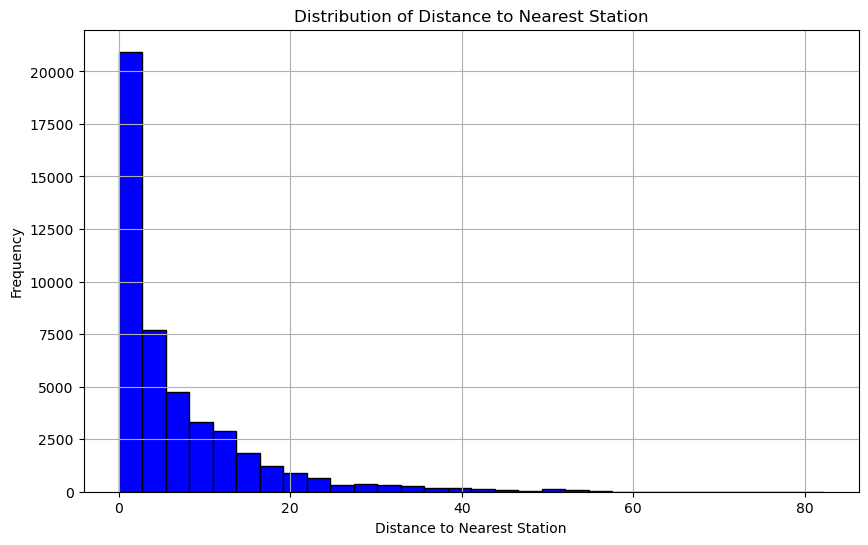

In [130]:
# Assuming 'distance_to_nearest_station' is the column name in bolig_df
plt.figure(figsize=(10, 6))
plt.hist(bolig_df_m_coordinates_u_BH['distance_to_nearest_station'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Distance to Nearest Station')
plt.xlabel('Distance to Nearest Station')
plt.ylabel('Frequency')
plt.grid(True)

# Show the plot
plt.show()

In [133]:
bolig_df_m_coordinates_u_BH['distance_to_nearest_station'].describe()

count    46214.000000
mean         6.704769
std          8.387950
min          0.011158
25%          1.217213
50%          3.415941
75%          9.169468
max         82.168083
Name: distance_to_nearest_station, dtype: float64